In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms

In [48]:
from tqdm import tnrange, tqdm_notebook

In [2]:
torch.manual_seed(0)
np.random.seed(0)

## Model Definition

In [83]:
class ConvLayer(nn.Module):
    """Convolution layer

    Arguments:
        in_channels (int): input channels
        out_channels (int): output channels

    """
    def __init__(self, in_channels, out_channels, pool=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.do_pool = pool
        if pool: self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv(x)
        if self.do_pool: x = self.pool(x)
        x = self.batch_norm(x)
        return F.relu(x)

In [84]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class CNN(nn.Module):
    def __init__(self:
        super().__init__()
        self.conv1 = ConvLayer(3,64)
        self.conv2 = ConvLayer(64,96, pool=True)
        self.conv3 = ConvLayer(96,96)
        self.conv4 = ConvLayer(96,128, pool=True)
        self.conv5 = ConvLayer(128,128)
        self.conv6 = ConvLayer(128,192, pool=True)
        self.faltten = Flatten
        self.fc1 = nn.Linear(192,512)
        
    def forward(self, x):
        x = self.conv1
        x = self.conv2
        x = self.conv3
        x = self.conv4
        x = self.conv5
        x = self.conv6
        x = self.fc1(self.flatten(x))
                 
                 
                 
                 
    

In [122]:
model = nn.Sequential(
    ConvLayer(3,64),
    ConvLayer(64,96, pool=True),
    ConvLayer(96,96),
    ConvLayer(96,128, pool=True),
    ConvLayer(128,128),
    ConvLayer(128,192, pool=True),
    Flatten(),
    nn.Linear(192,512),
    nn.Dropout(p=0.5),
    nn.Linear(512,10),
)

## Data

In [86]:
bs  = 1000

In [87]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [88]:
trainset = torchvision.datasets.CIFAR10(root="/home/ubuntu/data/",train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)


Files already downloaded and verified


In [89]:
testset = torchvision.datasets.CIFAR10(root="/home/ubuntu/data/",train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified


In [90]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### View Data

In [91]:
import matplotlib.pyplot as plt
import numpy as np

In [92]:
%matplotlib inline

In [93]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [94]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

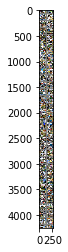

In [95]:
imshow(torchvision.utils.make_grid(images))

## Metrics

In [96]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

## Train Defintion

In [97]:
import torch.optim as optim

In [110]:
lr = 0.01
epochs = 5
drp_sample = 8

In [123]:
loss_func = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=lr)

In [124]:
# Might be a better way to do thiseg: pass model to fir function the pass parts to train_epoch ?
pre_drop_model = model[:8]
end_model = model[8:]

In [113]:
def train_epoch(train_loader, drp_sample):
    acc, loss_arr = [] ,[]
    for data in tqdm_notebook(train_loader, leave=False):
        inputs, labels = data

        optimiser.zero_grad()

        outputs = pre_drop_model(inputs)
        mulit_drops = [end_model(outputs)for _ in range(drp_sample)] # perfrom multisample dropout
        multi_lables = [labels for _ in range(drp_sample)] # match the labels
        
        # Join logits and labels
        final_out = torch.cat(mulit_drops)
        final_labels = torch.cat(multi_lables)
        
        acc.append(accuracy(final_out, final_labels))
        
        loss = loss_func(final_out, final_labels)
        loss_arr.append(loss.item())
        
        
        loss.backward() # Compute gradients
        optimiser.step() # update parametrs
    
    return acc , loss_arr 


In [114]:
def eval_batch(eval_dl, m):
    acc, loss_arr = [] ,[]
    m = model.eval()
    for data in eval_dl:
        inputs, labels = data
        
        logits = m(inputs)
        
        # Get accuraucy
        acc.append(accuracy(logits,labels))
        
        # Get loss
        loss = loss_func(logits,labels)
        loss_arr.append(loss.item())
        print(f'Acc{np.mean(acc)}')
    return acc, loss_arr
        
        
            
        

In [115]:
def fit(train_loader, eval_dl, epochs, drp_sample=1):
    tr_acc, tr_loss = [], [] # store metrics
    val_acc, val_loss = [], [] # store metrics
    
    for ep in tnrange(epochs):
        acc_ep, loss_ep = train_epoch(train_loader, drp_sample)
        tr_acc.extend(acc_ep)
        tr_loss.extend(loss_ep)
        print(f'Train - Loss:{np.mean(loss_ep[:-5]):.2f}, Acc:{np.mean(acc_ep[:-5]):.2f}')

#         val_acc_ep, val_loss_ep = eval_batch(eval_dl)
#         val_acc.extend(val_acc_ep)
#         val_loss.extend(val_loss_ep)
#         print(f'Valid - Loss:{np.mean(val_loss_ep[:-5]):.2f}, Acc:{np.mean(val_acc_ep[:-5]):.2f}')
        
        
    return tr_loss, tr_acc
    
    
    
    

In [116]:
# normal
history = fit(trainloader,testloader, 10)

Train - Loss:1.69, Acc:0.38


Train - Loss:1.23, Acc:0.56


Train - Loss:1.02, Acc:0.64


Train - Loss:0.87, Acc:0.69


Train - Loss:0.75, Acc:0.74


Train - Loss:0.67, Acc:0.77


Train - Loss:0.58, Acc:0.80


Train - Loss:0.51, Acc:0.82


Train - Loss:0.46, Acc:0.84


Train - Loss:0.40, Acc:0.86


In [117]:
loss, acc = history

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

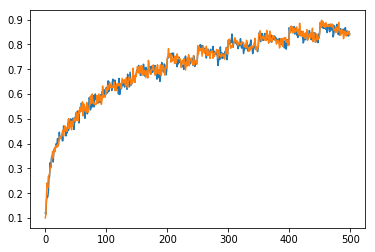

In [129]:
plt.plot(acc)
plt.plot(acc_8)

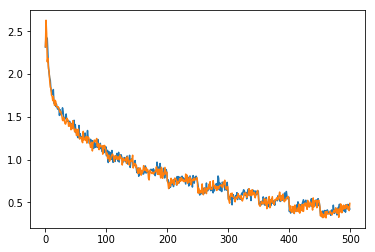

In [128]:
plt.plot(loss)
plt.plot(loss_8)

In [125]:
# 8 sample
history_8 = fit(trainloader,testloader, 10,  drp_sample=16)

Train - Loss:1.67, Acc:0.38


Train - Loss:1.22, Acc:0.55


Train - Loss:1.01, Acc:0.64


Train - Loss:0.86, Acc:0.70


Train - Loss:0.75, Acc:0.74


Train - Loss:0.67, Acc:0.77


Train - Loss:0.58, Acc:0.80


Train - Loss:0.52, Acc:0.82


Train - Loss:0.45, Acc:0.84


Train - Loss:0.40, Acc:0.87


In [127]:
loss_8, acc_8 = history_8

In [137]:
# 8 samples
%time
history_16 = fit(trainloader,testloader, 5, drp_sample=16)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs
Train - Loss:2.32, Acc:0.10
Train - Loss:2.32, Acc:0.10
Train - Loss:2.32, Acc:0.10
Train - Loss:2.32, Acc:0.10
Train - Loss:2.32, Acc:0.10
